# GLMsingle: single-trial estimation in rapid event-related design

This notebook is my attempt at applying the new GLMsingle toolbox to the SVD dataset. I am starting with the tutorial provided on the GLMsingle GitHub and modifying it for the SVD dataset. (LM)
https://htmlpreview.github.io/?https://github.com/kendrickkay/GLMsingle/blob/main/examples/example1.html   

By default, the tool implements a set of optimizations that improve upon generic GLM approaches by: (1) identifying an optimal hemodynamic response function (HRF) at each voxel, (2) deriving a set of useful GLM nuisance regressors via "GLMdenoise" and picking an optimal number to include in the final GLM, and (3) applying a custom amount of ridge regularization at each voxel using an efficient technique called "fracridge". The output of GLMsingle are GLM betas reflecting the estimated percent signal change in each voxel in response to each experimental stimulus or condition being modeled.

Example 1 contains a full walkthrough of the process of loading an example dataset and design matrix, estimating neural responses using GLMsingle, estimating the reliability of responses at each voxel, and comparing those achieved via GLMsingle to those achieved using a baseline GLM. After loading and visualizing formatted fMRI time-series and their corresponding design matrices, we will describe the default behavior of GLMsingle and show how to modify hyperparameters if the user desires. Throughout the notebook we will highlight important metrics and outputs using figures, print statements, and comments.

## A note about conda environments

When running this notebook, make sure you have activated the sklearn24 conda environment.

## Define subject

In [1]:
sub = 'sub-001'
ses = 'ses-01'
task='study'
n_runs=16 #session 1 runs

example = 1 #should we load example data?
load_epi = 1 #should we load raw epi data? Make sure this is set to 1 if you need to run GLMsingle from the start

## Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel import imagestats
import nilearn
from nilearn.input_data import NiftiMasker
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

%matplotlib inline 
%autosave 5
#sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


## Set paths and load settings

In [3]:
if example == 1:
    
    homedir = '/jukebox/norman/emcdevitt/glmsingle_example'

    # create directories for saving data and outputs(EXAMPLE)
    datadir = join(homedir,'examples','data')
    outputdir = join(homedir,'examples','example1outputs')

    os.makedirs(datadir,exist_ok=True)
    os.makedirs(outputdir,exist_ok=True)

    print(f'directory to save example dataset:\n\t{datadir}\n')
    print(f'directory to save example1 outputs:\n\t{outputdir}\n')

    # download example dataset from GLMsingle OSF repository
    # data comes from the NSD dataset (subj01, nsd01 scan session).
    # see: https://www.biorxiv.org/content/10.1101/2021.02.22.432340v1.full.pdf

    datafn = join(datadir,'nsdcoreexampledataset.mat')

    # to save time, we'll skip the download if the example dataset already exists on disk
    if not exists(datafn):

        print(f'Downloading example dataset and saving to:\n{datafn}')

        dataurl = 'https://osf.io/k89b2/download'

        # download the .mat file to the specified directory
        urllib.request.urlretrieve(dataurl, datafn)

    # load struct containing example dataset
    X = sio.loadmat(datafn)

directory to save example dataset:
	/jukebox/norman/emcdevitt/glmsingle_example/examples/data

directory to save example1 outputs:
	/jukebox/norman/emcdevitt/glmsingle_example/examples/example1outputs



## Organize BOLD data, design matrices, metadata

In [4]:
if example == 1:
    
    # variables that will contain bold time-series and design matrices from each run
    data = []
    design = []

    # iterate through each run of data
    for r in range(len(X['data'][0])):

        # index into struct, append each run's timeseries data to list
        data.append(X['data'][0,r])

        # convert each run design matrix from sparse array to full numpy array, append
        design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))

    # get shape of data volume (XYZ) for convenience
    xyz = data[0].shape[:3]
    xyzt = data[0].shape

    # get metadata about stimulus duration and TR
    stimdur = X['stimdur'][0][0]
    tr = X['tr'][0][0]

    # get visual ROI mask identifying occipital cortex
    roi = X['ROI']
    

In [5]:
print(tr)

1


In [11]:
print(design[0].shape)

(300, 583)


In [27]:
design[0][:,189]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [13]:
print(data[0].shape)

(145, 186, 1, 300)


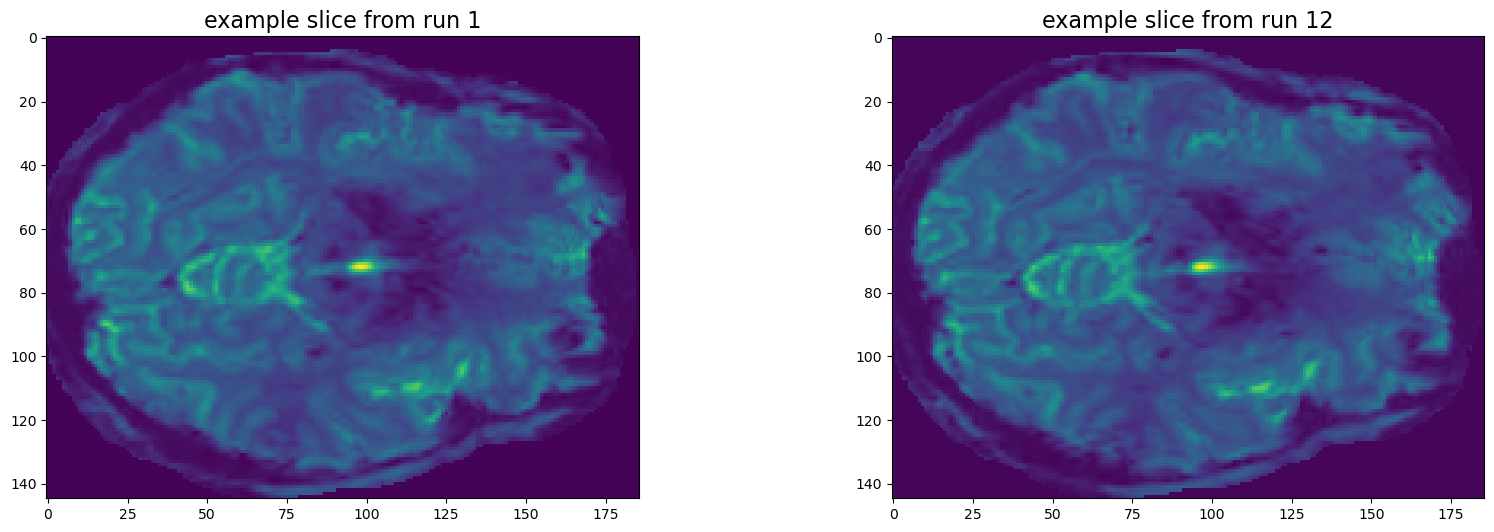

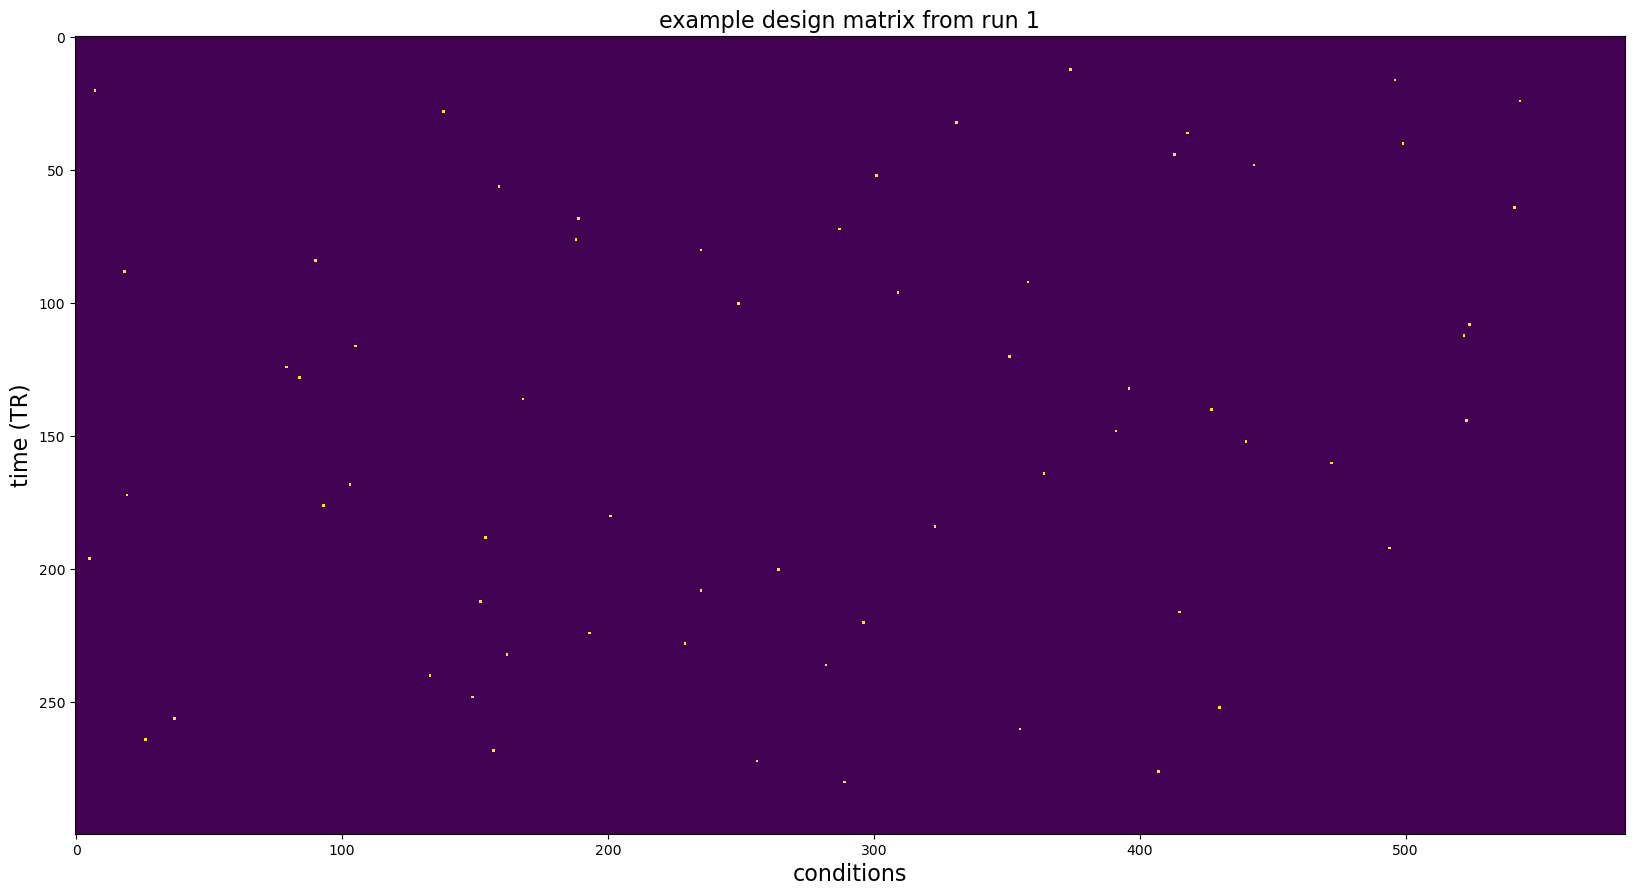

In [9]:
if example == 1:
    # plot example slice from run 1
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.imshow(data[0][:,:,0,0])
    plt.title('example slice from run 1',fontsize=16)
    plt.subplot(122)
    plt.imshow(data[11][:,:,0,0])
    plt.title('example slice from run 12',fontsize=16)

    # plot example design matrix from run 1
    plt.figure(figsize=(20,20))
    plt.imshow(design[0],interpolation='none')
    plt.title('example design matrix from run 1',fontsize=16)
    plt.xlabel('conditions',fontsize=16)
    plt.ylabel('time (TR)',fontsize=16)

- data[run#][x,y,z,t]
- roi[x,y,z]
- design[run#][TR,image#] 

note: in the design matrix, every row is an individual TR, and each distinct stimulus/condition (i.e. predictor) has its own column. There should be a column for every stimulus shown within a session, even if it doesn't occur during every run. 

A value of 1 in the design matrix indicates that the stimulus/condition occurred on a given TR.

In [12]:
example = 0
stimdur = 3
tr=1.5

In [8]:
# derivatives directory
homedir = '/jukebox/norman/emcdevitt/studies/mindeye/data/bids/'

# datadir is fmriprep folder for this subject, outputdir is glmsingle derivatives
datadir = join(homedir,'derivatives','fmriprep',sub,ses,'func')
#maskdir = join(homedir,'derivatives','firstlevel',sub,'masks')
designdir = '/jukebox/norman/emcdevitt/studies/mindeye/data/behavioral/regressor'
outputdir = join(homedir,'derivatives','glmsingle')

# os.makedirs(outputdir,exist_ok=True)

print(f'directory to load preprocessed data from:\n\t{datadir}\n')
print(f'directory to save outputs:\n\t{outputdir}\n')

directory to load preprocessed data from:
	/jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/fmriprep/sub-104/ses-01/func

directory to save outputs:
	/jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/glmsingle



I ran into an issue because of my small voxels, I have more than 1,000,000 "voxels" in my brain images (including voxels outside the brain).

I'm going to use NiftiMasker to apply the average brain mask to data, then instead of passing 4D (XYZT) images to data array, pass 2D (units x time) to data array.

In [9]:
# Load brain mask
file_in = maskdir + '/%s_%s_brain.nii.gz' % (sub, ses)
avg_mask=nib.load(file_in)
brain=avg_mask.get_fdata()
#xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Loading average brain mask:', file_in)
print('')
print('Mask dimensions:', avg_mask.header.get_zooms())
print('')
print('Affine:')
print(avg_mask.affine)
print('')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')

Loading average brain mask: /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/firstlevel/sub-104/masks/sub-104_ses-01_brain.nii.gz

Mask dimensions: (1.5, 1.5, 1.5)

Affine:
[[   1.5    0.     0.   -74. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -53.5]
 [   0.     0.     0.     1. ]]

There are 498249.0 voxels in the included brain mask



In [10]:
# get some info about epi data by loading run 1
epi_file=datadir + '/%s_%s_task-%s_run-01_space-T1w_desc-preproc_bold.nii.gz' % (sub,ses,task)
epi_data=nib.load(epi_file)
run1=epi_data.get_fdata()

print('checking epi data for run 1:', epi_file)
print('')
epi_dimsize=epi_data.header.get_zooms()
epi_affine=epi_data.affine
print('Dimensions:', epi_dimsize)
print('Affine:')
print(epi_data.affine)
print('')

# get shape of data volume (XYZ) for convenience
xyz = run1.shape[:3]
xyzt = run1.shape
print(xyz)
print(xyzt)

# double check that brain mask and epi data have same dimensions and affine
assert avg_mask.header.get_zooms() == epi_dimsize[:3]
assert avg_mask.affine.all() == epi_data.affine.all()


checking epi data for run 1: /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/fmriprep/sub-104/ses-01/func/sub-104_ses-01_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz

Dimensions: (1.5, 1.5, 1.5, 1.5)
Affine:
[[   1.5    0.     0.   -74. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -53.5]
 [   0.     0.     0.     1. ]]

(101, 126, 95)
(101, 126, 95, 406)


In [11]:
epi_masker=NiftiMasker(mask_img=avg_mask)

# variables that will contain bold time-series and design matrices from each run
data = []
label = []
TR_run = []

for run in range(n_runs):
    
    if load_epi == 1:
        epi_file=datadir + '/%s_%s_task-%s_run-0%i_space-T1w_desc-preproc_bold.nii.gz' % (sub,ses,task,run+1)
        print('loading data for run', run+1, ':', epi_file)
        print('')
        epi_mask_data = epi_masker.fit_transform(epi_file)
    
        # alternate to NiftiMasker
        # from nilearn.masking import apply_mask
        # masked_data = apply_mask(epi_file, mask_img)
    
        epi_mask_data = epi_mask_data.T #transpose to make it voxels,time
        #print('epi data shape:', epi_mask_data.shape)
    
        #epi_data=nib.load(epi_file)
        #epi=epi_data.get_fdata()
        data.append(epi_mask_data)
        TR_run.append(epi_mask_data.shape[1])
        
        print('BOLD data shape:', data[run].shape)
        print('TRs in this run:', TR_run[run])
    
    # load regressor file for each run
    # note: since each regressor has 9TRs trimmed from the beginning of the file,
    # we are going to add 9 blank TRs back to the beginning of each file
    
    regressor_file=designdir + '/%s_%s_task-%s_regressor-noshift-trim9TRs-reshaped_run-0%i.mat' % (sub,ses,task,run+1)
    stim_label = scipy.io.loadmat(regressor_file)
    stim_label = np.array(stim_label['regressor'])
    # add 9 TRs back to beginning of file
    stim_label = np.concatenate((np.zeros((18,9), dtype=int),stim_label),axis=1) # trim label end
    if load_epi == 1:
        assert stim_label.shape[1] == epi_mask_data.shape[1] #make sure number of timepoints matches
    label.append(stim_label)
    print('label file shape:', label[run].shape)
    print('')
    

if load_epi == 1:
    print('number of runs in BOLD data:', len(data))   
print('number of runs in label data:', len(label))

# get shape of data volume (XYZ) for convenience
#xyz = data[0].shape[:3]
#xyzt = data[0].shape

loading data for run 1 : /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/fmriprep/sub-104/ses-01/func/sub-104_ses-01_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz

BOLD data shape: (498249, 406)
TRs in this run: 406
label file shape: (18, 406)
loading data for run 2 : /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/fmriprep/sub-104/ses-01/func/sub-104_ses-01_task-study_run-02_space-T1w_desc-preproc_bold.nii.gz

BOLD data shape: (498249, 406)
TRs in this run: 406
label file shape: (18, 406)
loading data for run 3 : /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/fmriprep/sub-104/ses-01/func/sub-104_ses-01_task-study_run-03_space-T1w_desc-preproc_bold.nii.gz

BOLD data shape: (498249, 406)
TRs in this run: 406
label file shape: (18, 406)
loading data for run 4 : /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v

In [12]:
# print some relevant metadata
if load_epi == 1:
    print(f'There are {n_runs} runs in total\n')
    #print(f'N = {data[0].shape[1]} TRs per run\n')
    print(f'XYZ dimensionality is: {xyz}\n')
    print(f'The dimensions of the 2D data for each run are:\n {data[0].shape}\n {data[1].shape}\n {data[2].shape}\n {data[3].shape}\n {data[4].shape}\n {data[5].shape}\n')
    print(f'The stimulus duration is {stimdur} seconds\n')
    print(f'The TR is {tr} seconds\n')
    print(f'There are {np.sum(brain)} voxels in the included brain mask\n')
    #print(f'There are {np.sum(roi)} voxels in the included visual ROI\n')
    print(f'Numeric precision of data is: {type(data[0][0,0])}\n')


There are 6 runs in total

XYZ dimensionality is: (101, 126, 95)

The dimensions of the 2D data for each run are:
 (498249, 406)
 (498249, 406)
 (498249, 406)
 (498249, 406)
 (498249, 406)
 (498249, 406)

The stimulus duration is 1 seconds

The TR is 1.5 seconds

There are 498249.0 voxels in the included brain mask

Numeric precision of data is: <class 'numpy.float64'>



In [13]:
# # plot example slice from run 1 and run 6
# z=45
# plt.figure(figsize=(20,6))
# plt.subplot(121)
# plt.imshow(data[0][:,:,z,0])
# plt.title('example slice from run 1',fontsize=16)
# plt.subplot(122)
# plt.imshow(data[5][:,:,z,0])
# plt.title('example slice from run 6',fontsize=16)

## info about rows in label file:
row info found here: 
/jukebox/norman/emcdevitt/studies/SVD/data/behavioral/regressor/task-study_regRow_reshaped.mat
note: every column is a TR in the label file

* condition (prelearning=3, vio=1, nonvio=2)
* repetition #
* pairID (within-condition, within-run)
* inter-pair-interval
* order (A=1 or B=2)
* lower (subcategory: indoor or outdoor, male or female)
* upper (category: face=1 or scene=2)
* imgID
* learningBlk
* trialNum
* time (goal onset time)
* response
* RT
* accuracy
* TRs_original
* TRs_trimmed
* uniqueImgID
* exposureNum

In [14]:
study_row_labels={'cond': 0, 'repetition': 1, 'pairID_orig': 2, 'ipi': 3, 'order': 4, 'subcategory': 5,
                'category': 6, 'imgID': 7, 'learningBlk': 8, 'learningTrial': 9, 'time': 10,
                'response': 11, 'rt': 12, 'accuracy': 13, 'tr_original': 14, 'tr_trimmed': 15,
                'uniquePairID': 16, 'exposureNum': 17, 'index': 18} #index and cond_orig rows to be added
print(study_row_labels)

{'cond': 0, 'repetition': 1, 'pairID_orig': 2, 'ipi': 3, 'order': 4, 'subcategory': 5, 'category': 6, 'imgID': 7, 'learningBlk': 8, 'learningTrial': 9, 'time': 10, 'response': 11, 'rt': 12, 'accuracy': 13, 'tr_original': 14, 'tr_trimmed': 15, 'uniquePairID': 16, 'exposureNum': 17, 'index': 18}


In [15]:
# Version: model all As as repeats; all Bs, Xs and Ys are unique events
# 96 pairs total, each B is shown 6 times during session 1
n_A = 96
n_B = 96*6
n_X = 48
n_Y = 48
n_conditions = n_A+n_B+n_X+n_Y
print(n_conditions)
print('number of B conditions:', n_B)

768
number of B conditions: 576


uniquePairID, 1-48=cond1 and 49-96=cond2:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 49. 50. 51. 52. 53. 54. 55. 56.]

uniquePairID, 1-48=cond1 and 49-96=cond2:
[ 0.  9. 10. 11. 12. 13. 14. 15. 16. 57. 58. 59. 60. 61. 62. 63. 64.]

uniquePairID, 1-48=cond1 and 49-96=cond2:
[ 0. 17. 18. 19. 20. 21. 22. 23. 24. 65. 66. 67. 68. 69. 70. 71. 72.]

uniquePairID, 1-48=cond1 and 49-96=cond2:
[ 0. 25. 26. 27. 28. 29. 30. 31. 32. 73. 74. 75. 76. 77. 78. 79. 80.]

uniquePairID, 1-48=cond1 and 49-96=cond2:
[ 0. 33. 34. 35. 36. 37. 38. 39. 40. 81. 82. 83. 84. 85. 86. 87. 88.]

uniquePairID, 1-48=cond1 and 49-96=cond2:
[ 0. 41. 42. 43. 44. 45. 46. 47. 48. 89. 90. 91. 92. 93. 94. 95. 96.]



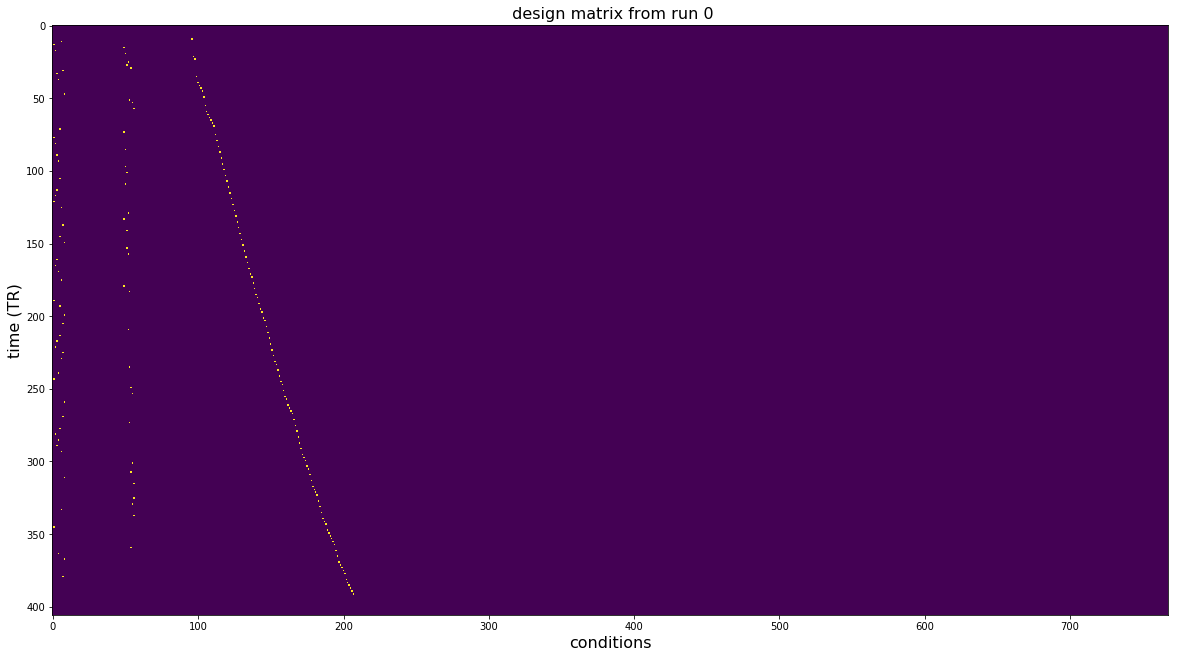

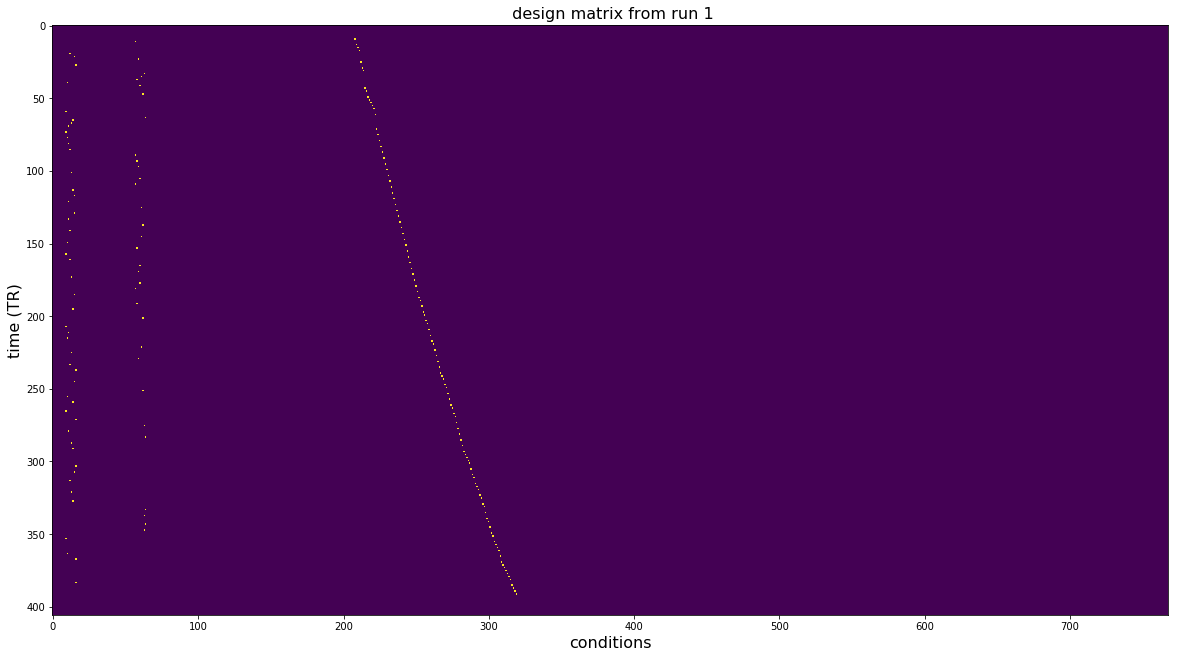

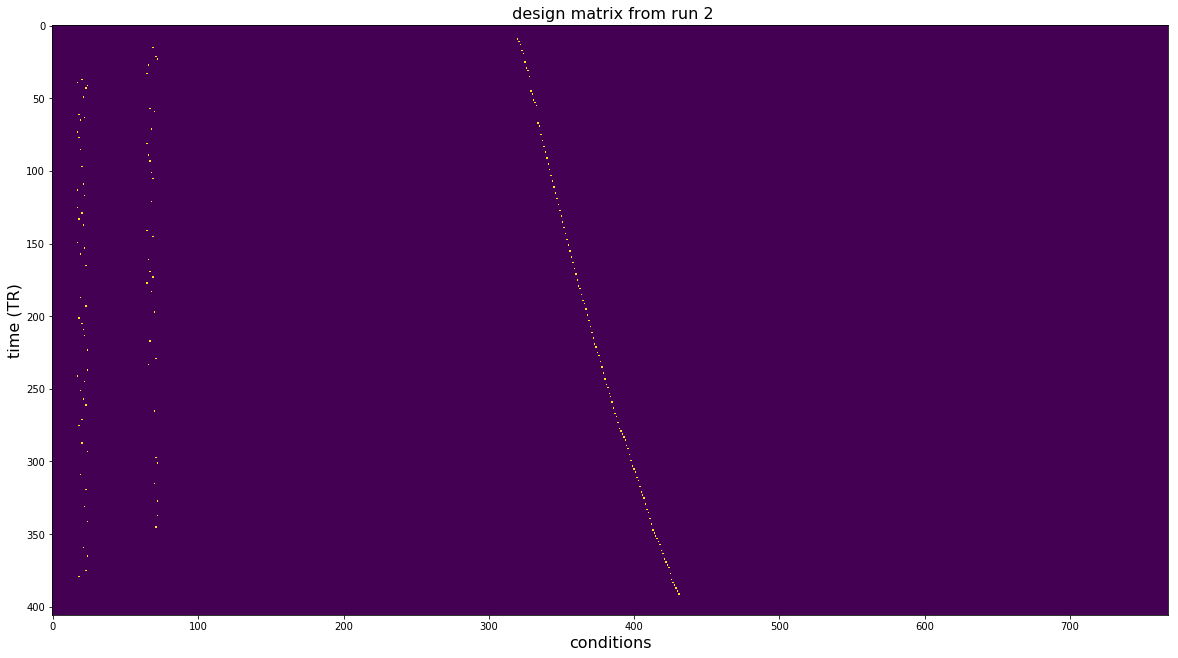

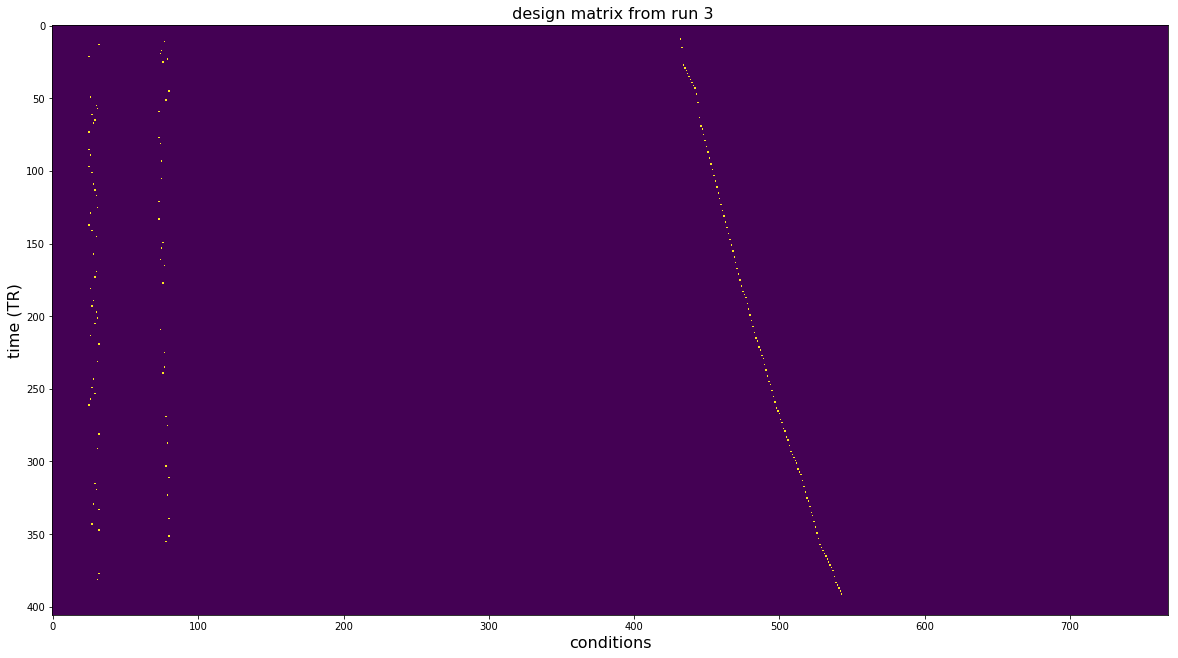

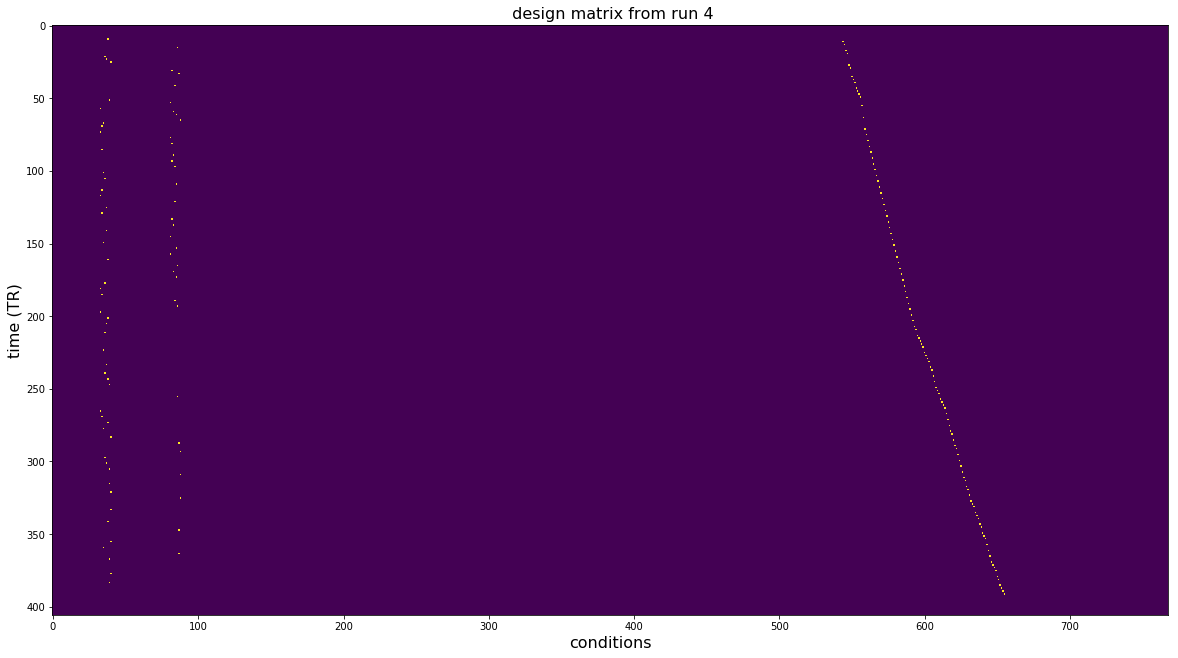

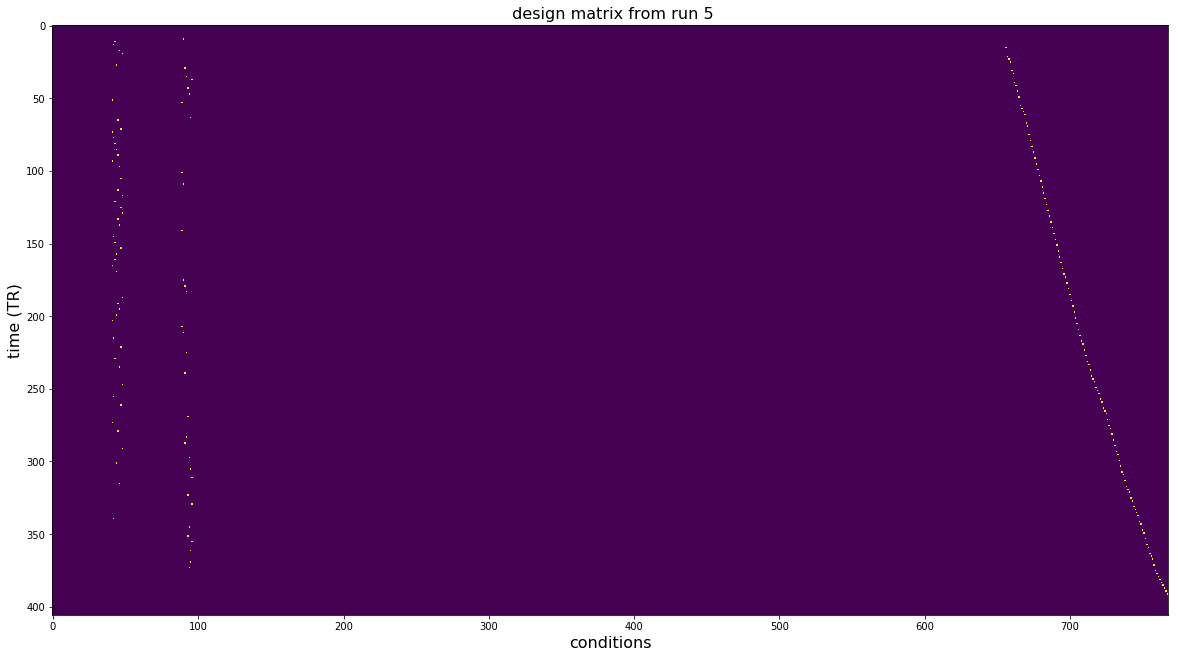

In [16]:
#design[run#][TR,image#]
design = []
Blist = [x for x in range(n_A, n_conditions)] # B items (including Xs and Ys) will be conditions 96-767

for run in range(n_runs):
    temp = np.zeros((data[run].shape[1],n_conditions), dtype=int)
    
    print('uniquePairID, 1-48=cond1 and 49-96=cond2:')
    print(np.unique(label[run][study_row_labels['uniquePairID'],:])) # IDs 1-48=cond1, 49-96=cond2
    print('')
    
    # A items will always be conditions 0-95
    # B items will be conditions 96-671
    # X and Y will be conditions 672-767
    
    # idx is TR, x is the uniquePairID
    for idx, x in enumerate(label[run][study_row_labels['uniquePairID'],:]):
        if x > 0: #if an image is shown
            AorB = label[run][study_row_labels['order'],idx]
            #print(idx, x, AorB)
            if AorB == 1: #if it's an A item
                temp[idx,int(x)] = 1
            elif AorB == 2: #if it's a B item
                # sample without replacement from Blist (sampling order doesn't need to be random)
                this_condition = Blist[0]
                del Blist[0]
                temp[idx,this_condition] = 1
    
    design.append(temp)
    
    # plot design matrix
    plt.figure(figsize=(20,20))
    plt.imshow(temp,interpolation='none')
    plt.title(' design matrix from run %i' %run, fontsize=16)
    plt.xlabel('conditions',fontsize=16)
    plt.ylabel('time (TR)',fontsize=16)       
    
    

In [17]:
design[0] #save this to csv and check it

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Run GLMsingle with default parameters to estimate single-trial betas

In [18]:
# outputs and figures will be stored in a folder (you can specify its name
# as the 5th output to GLMsingle). model estimates can be also
# saved to the 'results' variable which is the only output of
# GLMsingle.

# optional parameters below can be assigned to a structure, i.e., opt =
# dict('wantlibrary':1, 'wantglmdenoise':1); options are the 6th input to
# GLMsingle.

# there are many options that can be specified; here, we comment on the
# main options that one might want to modify/set. defaults for the options
# are indicated below.

# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
# chunklen = 50000 -> is the number of voxels that we will
#    process at the same time. for setups with lower memory, you may need to 
#    decrease this number.

# wantmemoryoutputs is a logical vector [A B C D] indicating which of the
#     four model types to return in the output <results>. the user must be
#     careful with this, as large datasets can require a lot of RAM. if you
#     do not request the various model types, they will be cleared from
#     memory (but still potentially saved to disk). default: [0 0 0 1]
#     which means return only the final type-D model.

# wantfileoutputs is a logical vector [A B C D] indicating which of the
#     four model types to save to disk (assuming that they are computed). A
#     = 0/1 for saving the results of the ONOFF model, B = 0/1 for saving
#     the results of the FITHRF model, C = 0/1 for saving the results of the
#     FITHRF_GLMdenoise model, D = 0/1 for saving the results of the
#     FITHRF_GLMdenoise_RR model. default: [1 1 1 1] which means save all
#     computed results to disk.

# numpcstotry (optional) is a non-negative integer indicating the maximum
#     number of GLMdenoise PCs to enter into the model. default: 10.

# fracs (optional) is a vector of fractions that are greater than 0
#     and less than or equal to 1. we automatically sort in descending
#     order and ensure the fractions are unique. these fractions indicate
#     the regularization levels to evaluate using fractional ridge
#     regression (fracridge) and cross-validation. default:
#     fliplr(.05:.05:1). a special case is when <fracs> is specified as a
#     single scalar value. in this case, cross-validation is NOT performed
#     for the type-D model, and we instead blindly use the supplied
#     fractional value for the type-D model.

In [21]:
# create a directory for saving GLMsingle outputs
#outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')
outputdir_glmsingle = join(homedir,'v1.2.3_derivatives','glmsingle_2', sub, ses)
figuredir_glmsingle = join(homedir,'v1.2.3_derivatives','glmsingle_2', 'figures', sub, ses)
#os.makedirs(outputdir,exist_ok=True)

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]
#opt['wanthdf5'] = 1

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1652286407.4488637,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [22]:
print('shape of data before running GLMsingle:')
print(data[0].shape)

shape of data before running GLMsingle:
(498249, 406)


In [ ]:
# ADD FIGUREDUR
# Try running with brainexclude=avg_mask
# if it crashes, then increase max to 1,500,000

# this example saves output files to the outputdir folder
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

if not exists(outputdir_glmsingle):
    print('saving outputs to', outputdir_glmsingle)
    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle,
       figuredir=figuredir_glmsingle)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    # takes about 2 minutes to load
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

saving outputs to /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/glmsingle_2/sub-104/ses-01
running GLMsingle...
*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/glmsingle_2/sub-104/ses-01/TYPEA_ONOFF.npy. ***

*** Setting brain R2 threshold to 0.23834858246500157 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks:  10%|█         | 1/10 [04:55<44:23, 295.96s/it]

## Summary of important outputs

the outputs of GLMsingle are formally documented in its header. here, we highlight a few of the more important outputs:

* R2 -> is model accuracy expressed in terms of R^2 (percentage).

* betasmd -> is the full set of single-trial beta weights (X x Y x Z x TRIALS). beta weights are arranged in chronological order.

* HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered with getcanonicalHRFlibrary(stimdur,tr)

* FRACvalue -> is the fractional ridge regression regularization level chosen for each voxel. values closer to 1 mean less regularization.

In [ ]:
# GLMsingle output is in 2D format (voxels,samples)
# we need to unmask the data to get it back into 3D/4D format:
# X = nilearn.masking.unmask(results_glmsingle['typeb']['HRFindex'], avg_mask)
# X_hrf = X.get_fdata()

In [ ]:
# results_out = {
#                     'onoffR2': np.reshape(onoffR2, [nx, ny, nz]),
#                     'meanvol': np.reshape(meanvol, [nx, ny, nz]),
#                     'betasmd': np.reshape(betasmd, [nx, ny, nz])
#                     }

In [28]:
# convert everything back to 3D/4D array format
model_types = ['typea','typeb','typec','typed']

results_glmsingle_3D = dict()

for model in range(len(model_types)):
    results_glmsingle_3D[model_types[model]] = dict()
    if model == 0: #type A
        plot_fields = ['betasmd','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','R2','HRFindex']
    elif model == 2: #type C
        plot_fields = ['betasmd','R2','HRFindex']
    elif model == 3: #type C
        plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
    print(model_types[model])
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        unmask_data = nilearn.masking.unmask(results_glmsingle[model_types[model]][plot_fields[i]].T, avg_mask)
        results_glmsingle_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_glmsingle_3D[model_types[model]][plot_fields[i]].shape)
        print('')

typea
betasmd
shape of unmasked data: (101, 126, 95, 1)

onoffR2
shape of unmasked data: (101, 126, 95)

typeb
betasmd
shape of unmasked data: (101, 126, 95, 1152)

R2
shape of unmasked data: (101, 126, 95)

HRFindex
shape of unmasked data: (101, 126, 95)

typec
betasmd
shape of unmasked data: (101, 126, 95, 1152)

R2
shape of unmasked data: (101, 126, 95)

HRFindex
shape of unmasked data: (101, 126, 95)

typed
betasmd
shape of unmasked data: (101, 126, 95, 1152)

R2
shape of unmasked data: (101, 126, 95)

HRFindex
shape of unmasked data: (101, 126, 95)

FRACvalue
shape of unmasked data: (101, 126, 95)



## Plot a slice of brain showing GLMsingle outputs

plot_data shape after reshaping: (101, 126, 95)
plot_data shape after reshaping: (101, 126, 95)


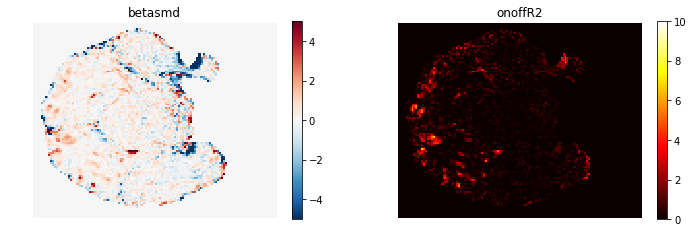

In [113]:
# Plot a slice showing ONOFF betas (this should correspond to areas that respond to visual stimulus)
z=30
plot_fields = ['betasmd','onoffR2']
colormaps = ['RdBu_r','hot']
clims = [[-5,5],[0,10]]

plt.figure(figsize=(12,8))
for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)

    plot_data = np.squeeze(results_glmsingle_3D['typea'][plot_fields[i]].reshape(xyz))
    print('plot_data shape after reshaping:', plot_data.shape)
    titlestr = plot_fields[i]
    
    plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    #plt.axis(False)
    plt.axis('off')

plot_data shape after averaging across trials: (101, 126, 95)
plot_data shape after reshaping: (101, 126, 95)
plot_data shape after reshaping: (101, 126, 95)
plot_data shape after reshaping: (101, 126, 95)


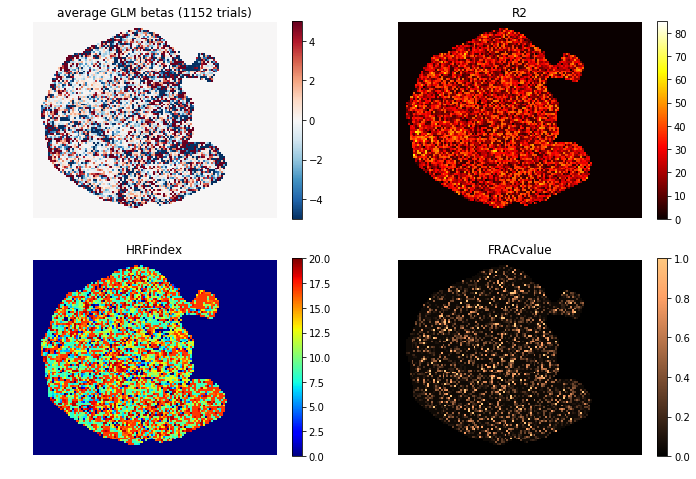

In [112]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

# choose a slice
z=30

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
#     unmask_data = nilearn.masking.unmask(results_glmsingle['typed'][plot_fields[i]].T, avg_mask)
#     plot_array = unmask_data.get_fdata()
#     print('shape after unmasking:', plot_array.shape)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        #plot_data = np.nanmean(np.squeeze(plot_array),3)
        num_trials = results_glmsingle_3D['typed'][plot_fields[i]].shape[3]
        plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]]),3) #3 is trial dimension
        print('plot_data shape after averaging across trials:', plot_data.shape)
        titlestr = 'average GLM betas (%d trials)' %num_trials
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        #plot_data = np.squeeze(plot_array.reshape(xyz))
        plot_data = np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]].reshape(xyz))
        print('plot_data shape after reshaping:', plot_data.shape)
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    #plt.axis(False)
    plt.axis('off')

## Run a baseline GLM to compare with GLMsingle outputs

In [33]:
# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise, or ridge regression regularization. we
# will compute the split-half reliability at each voxel using this baseline
# GLM, and then assess whether reliability improves using the output betas
# from GLMsingle. 

# output directory for baseline GLM
outputdir_baseline = join(homedir,'v1.2.3_derivatives','glmsingle', 'glmbaseline', sub, ses)

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression


# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed
opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
pprint(glmbaseline_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1652211692.656873,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wanthdf5': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [34]:
start_time = time.time()

# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.
if not exists(outputdir_baseline):
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
else:
    
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_baseline}')
    
    results_assumehrf = dict()
    results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.
    
elapsed_time = time.time() - start_time
print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

loading existing GLMsingle outputs from directory:
	/jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/v1.2.3_derivatives/glmsingle/glmbaseline/sub-104/ses-01
	elapsed time:  00:00:27


In [36]:
# convert back to 3D/4D array format
model_types = ['typea','typeb']

results_assumehrf_3D = dict()

for model in range(len(model_types)):
    results_assumehrf_3D[model_types[model]] = dict()
    if model == 0: #type A
        plot_fields = ['betasmd','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','R2','HRFindex']
    print(model_types[model])
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        unmask_data = nilearn.masking.unmask(results_assumehrf[model_types[model]][plot_fields[i]].T, avg_mask)
        results_assumehrf_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_assumehrf_3D[model_types[model]][plot_fields[i]].shape)
        print('')

typea
betasmd
shape of unmasked data: (101, 126, 95, 1)

onoffR2
shape of unmasked data: (101, 126, 95)

typeb
betasmd
shape of unmasked data: (101, 126, 95, 1152)

R2
shape of unmasked data: (101, 126, 95)

HRFindex
shape of unmasked data: (101, 126, 95)



In [37]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf_3D['typeb']['betasmd'].reshape(xyz + (num_trials,))
models['fithrf'] = results_glmsingle_3D['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle_3D['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle_3D['typed']['betasmd']

## Get indices of repeated conditions to use for reliability calculations

In [38]:
# to compare the results of different GLMs we are going to calculate the
# voxel-wise split-half reliablity for each model. reliability values
# reflect a correlation between beta weights for repeated presentations of
# the same conditions. in short, we are going to check how
# reliable/reproducible are the single trial responses to repeated
# conditions estimated with each GLM type.

# this NSD scan session has a large number of images that are just shown
# once during the session, some images that are shown twice, and a few that
# are shown three times. in the code below, we are attempting to locate the
# indices in the beta weight GLMsingle outputs modelmd(x,y,z,trials) that
# correspond to repeated images. here we only consider stimuli that have
# been presented at least twice. for the purpose of the example we ignore
# the 3rd repetition of the stimulus.

# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)

In [45]:
# let's take a look at the first few entries
print(corder[:3])

# note that [374 496 7] means that the first stimulus trial involved
# presentation of the 374th condition (zero-indexed), the second stimulus trial 
# involved presentation of the 496th condition, and so on.

[96  6  1]


In [68]:
# in order to compute split-half reliability, we have to do some indexing.
# we want to find images with least two repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

repindices = [] # 4 x images containing stimulus trial indices.

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for p in range(designALL.shape[1]): # loop over every condition
    
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    
    # only add repeated conditions to repindices
    if len(temp) >= 2:
        repindices.append([temp[0], temp[1], temp[2], temp[3]]) # note that for now we only look at first 4 repetitions of A 

repindices = np.vstack(np.array(repindices)).T   
print(repindices.shape)

(4, 96)


In [67]:
# let's take a look at a few entries
print(repindices[:,:3])

# notice that the first condition is presented on the 2nd zero-indexed 
# stimulus trial and the 34th, 56th, and 90th stimulus trial, the second condition is presented on the
# 4th and 36th, 54th and 78th stimulus trials, and so on.

print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

# now, for each voxel we are going to correlate beta weights describing the
# response to images presented for the first time with beta weights
# describing the response from the repetition of the same image. with 136
# repeated conditions, the correlation for each voxel will reflect the
# relationship between two vectors with 136 beta weights each.

[[ 2  4 12]
 [34 36 40]
 [56 54 52]
 [90 78 76]]
there are 96 repeated conditions in the experiment


## Visualize corticle ROI defining visually-responsive areas

In [101]:
# load mask
mask = 'bilateral_oc-temp'
roi = []
mask_file=maskdir + '/%s_%s.nii.gz' % (sub,mask)
mask_data=nib.load(mask_file)
roi=mask_data.get_fdata()

assert mask_data.header.get_zooms() == epi_dimsize[:3]
assert mask_data.affine.all() == epi_data.affine.all()
print('roi shape:', roi.shape)
print(np.min(roi), np.max(roi))

roi shape: (101, 126, 95)
0.0 1.0


In [107]:
octemp_roi = roi.astype(float)
# convert voxels outside ROI to nan for overlay plotting
octemp_roi[octemp_roi==0] = np.nan 
print(np.nanmin(octemp_roi), np.nanmax(octemp_roi))
print(octemp_roi.shape)

1.0 1.0
(101, 126, 95)


Text(0.5, 1.0, 'voxels in octemp ROI')

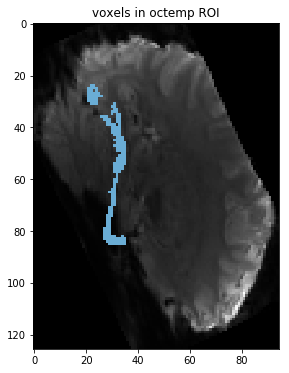

In [127]:
# get mask defining liberal visual cortex ROI. "nsdgeneral" is a general ROI 
# that was manually drawn on fsaverage covering voxels responsive to the NSD experiment 
# in the posterior aspect of cortex. for the sake of simplicity we will focus 
# on voxels within this ROI in computing split-half reliability

# get mean fMRI volume from run 1
meanvol = np.squeeze(np.mean(run1.reshape(xyzt),axis=3))

# plot ROI on top of overlay
x=35
plt.figure(figsize=(12,6))
plt.imshow(meanvol[x,:,:],cmap='gray')
plt.imshow(octemp_roi[x,:,:],cmap='Blues',clim=(0,2))

plt.title('voxels in octemp ROI')
#plt.box(False)
#plt.axis(False);

## Compute median split-half reliabilty within the ROI for each beta version

In [120]:
# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them

vox_reliabilities = [] # output variable for reliability values

modelnames = list(models.keys())

# for each beta version...
for m in range(len(modelnames)):
    
    print(f'computing reliability for beta version: {modelnames[m]}')
    time.sleep(1)
    
    # get the repeated-condition GLM betas using our repindices variable
    betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
    x,y,z = betas.shape[:3] 
    
    rels = np.full((x,y,z),np.nan)
    
    # loop through voxels in the 3D volume...
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                
                # reliability at a given voxel is pearson correlation between response profiles from first and 
                # second image presentations (dim = 136 conditions)
                rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                             betas[xx,yy,zz,1])[1,0]
          
    vox_reliabilities.append(rels)

computing reliability for beta version: assumehrf


100%|██████████| 101/101 [01:41<00:00,  1.01s/it]


computing reliability for beta version: fithrf


100%|██████████| 101/101 [01:43<00:00,  1.02s/it]


computing reliability for beta version: fithrf_glmdenoise


100%|██████████| 101/101 [01:44<00:00,  1.04s/it]


computing reliability for beta version: fithrf_glmdenoise_rr


100%|██████████| 101/101 [01:43<00:00,  1.02s/it]


## Assess change in reliability yielded by GLMsingle

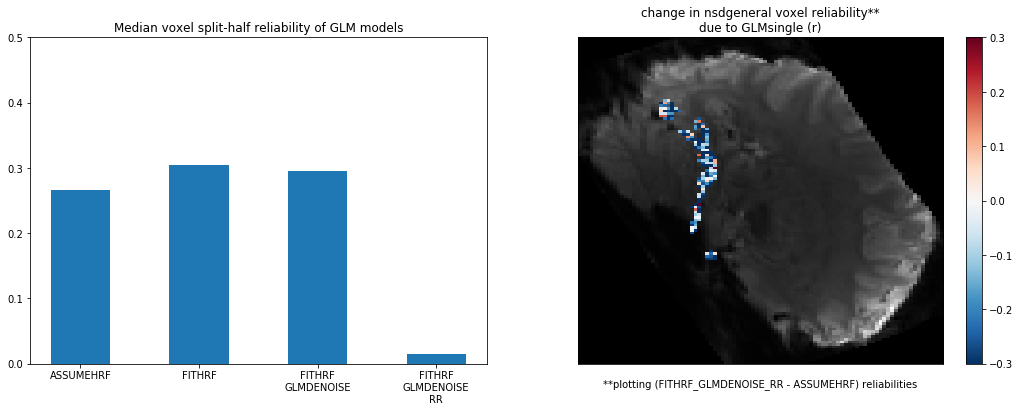

In [135]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph

comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmedian(vr[octemp_roi==1]))

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(4),np.array(['ASSUMEHRF', 'FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));
plt.ylim([0,0.5])

# draw plot showing the change in reliability between the baseline GLM
# and the final output of GLMsingle (fithrf-glmdenoise-RR betas)
vox_improvement = np.squeeze(vox_reliabilities[3] - vox_reliabilities[0])
vox_improvement[octemp_roi != 1] = np.nan

plt.subplot(122)
plt.imshow(meanvol[x,:,:],cmap='gray',aspect='auto')
plt.imshow(vox_improvement[x,:,:],cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto')
plt.colorbar()
plt.title('change in nsdgeneral voxel reliability**\ndue to GLMsingle (r)')
plt.xticks([])
plt.yticks([])
plt.xlabel('\n**plotting (FITHRF_GLMDENOISE_RR - ASSUMEHRF) reliabilities');

# notice that there is systematic increase in reliability moving from the
# first to the second to the third to the final fourth version of the GLM
# results. these increases reflect, respectively, the addition of HRF
# fitting, the derivation and use of data-driven nuisance regressors, and
# the use of ridge regression as a way to regularize the instability of
# closely spaced experimental trials. depending on one's experimental
# goals, it is possible with setting of option flags to activate a subset
# of these analysis features.

# also, keep in mind that in the above figure, we are simply showing the
# median as a metric of the central tendency (you may want to peruse
# individual voxels in scatter plots, for example).

In [134]:
comparison

[0.2659569387298219,
 0.3042045059201569,
 0.2955979698440061,
 0.015412392629105976]